### Neural Network From Scratch Attempt #3

In [2]:
from IPython.core.interactiveshell import InteractiveShell
import struct
import numpy as np
import tensorflow.experimental.numpy as tnp
import tensorflow as tf
import matplotlib.pyplot as plt
import time as time
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

# Usage example:
train_X = read_idx('../Data/mnist/train-images-idx3-ubyte')
train_y = read_idx('../Data/mnist/train-labels-idx1-ubyte')
test_X = read_idx('../Data/mnist/t10k-images-idx3-ubyte')
test_y = read_idx('../Data/mnist/t10k-labels-idx1-ubyte')

/var/folders/0z/9nrqpdg94f9976b246v2q0jm0000gn/T/ipykernel_8155/2929329053.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


In [4]:
train_X.shape

(60000, 28, 28)

In [8]:
# (train_X, train_y), (test_X, test_y) = mnist.load_data()
num_pixels = train_X.shape[1]*train_X.shape[2]
# flatten X
train_X = train_X.reshape(train_X.shape[0], num_pixels).astype('float32')
test_X = test_X.reshape(test_X.shape[0], num_pixels).astype('float32')
# one hot categorical Y
train_hot = np.eye(np.max(train_y)+1)[train_y].astype('float32')
test_hot = np.eye(np.max(test_y)+1)[test_y].astype('float32')
# lets put these back together so that we can actually shuffle them later (normalize too)
X = np.concatenate((train_X, test_X), axis=0)/255
Y = np.concatenate((train_hot, test_hot), axis=0)

m = 70000


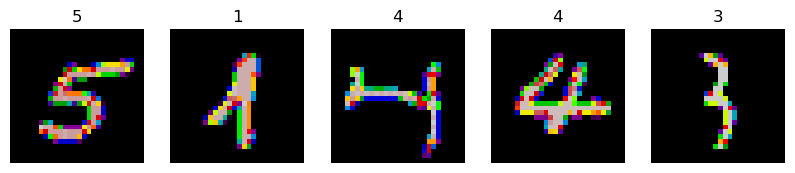

In [9]:
m = X.shape[0]
print(f'm = {m}')
n = 5
fig,axs = plt.subplots(1, n, figsize=(10,2),dpi=100)
for i in range(n):
    rnd = np.random.randint(m)
    # plotting first few images from the dataset
    _=axs[i].imshow(X[rnd].reshape(28,28), cmap=plt.get_cmap('nipy_spectral'))
    _=axs[i].set_title(f'{np.argmax(Y[rnd])}')
    _=axs[i].axis('off')

<center><u>components of the gradient</u></center>
<br>
<center>regression predicts variables $w, b$</center>

<center>$x, y$ are constants</center>
<br>
<center><u>logistic regression process</u></center>

$$Z = W^TX + B$$

$$A = \sigma(Z)$$

$$A_{outputs} = \hat{Y}$$

$$L = L(\hat{Y}, Y) = L(A_{out}, y)$$

$$L\ = - y \log{(A_{out})}\ +\ (1 - y)\log{(1 - A_{out})}$$

<center>so we need the output of the forward pass i.e.  

$$\hat{y}$$

to compute the derivative of the loss function</center>

<center><u>Chain Rule</u></center>

$$Z \rightarrow A \rightarrow L$$

$$z = w_1x_1 + w_2x_2 + \ldots + b$$

$$dw_1 =  \frac{dL}{dw_1} = \frac{\partial{L}}{\partial{z}} \cdot \frac{\partial{z}}{\partial{w_1}}$$

$$ = x_1 \cdot \frac{\partial{z}}{\partial{w_1}}$$

$$dw_2 =  \frac{dL}{dw_2} = \frac{\partial{L}}{\partial{z}} \cdot \frac{\partial{z}}{\partial{w_2}}$$

$$ = x_2 \cdot \frac{\partial{z}}{\partial{w_2}}$$

$$dw_b =  \frac{dL}{db} = \frac{\partial{L}}{\partial{z}} \cdot \frac{\partial{z}}{\partial{b}}$$

$$ ? = \frac{\partial{z}}{\partial{b}}$$

***

$$\frac{\partial{z}}{\partial{w_1}} + \frac{\partial{z}}{\partial{w_2}} + \ldots \frac{\partial{z}}{\partial{w_m}} + \frac{\partial{z}}{\partial{b}} = dZ$$

$$dz = \frac{\partial{L}}{\partial{z}} = \frac{\partial{L}}{\partial{a}} \cdot \frac{\partial{a}}{\partial{z}}$$

$$ = \bigl( - \frac{y}{a} + \frac{1-y}{1-a}\bigr) \cdot a(1-a)$$

$$ = a - y$$

***

$$da = \frac{\partial{L}}{\partial{a}} = - \frac{y}{a} + \frac{1-y}{1-a}$$

In [67]:
class ann():
    # sizes are a list describing the dense layers
    # the itnput size and output size for now will be inferred
    # from the size of the X and Y data
    # likely  could implement something where itnput and output layer are  not  produced  
    # until data is offered, im not sure if this is a bad idea. ill have to research a bit.
    # data examples are expected to be provided as rows
    def __init__(self, sizes=None, epochs=1, rate=0.001, X=None, Y=None):
        self.sizes = None
        self.num_layers = None
        self.m = None
        self.X = X
        self.Y = Y
        self.J = None
        self.x = None
        self.y = None
        self.batch_size=0
        self.times = []
        self.test_run = False
        self.split_data = None
        self.foreign_split = False
        self.epochs = epochs
        self.lr = rate
        self.params = self.build_init(sizes)
    
    def build_init(self, sizes:list=None, acv_hidden:object=None, acv_output:object=None, overwrite=False):
        if self.sizes is None:
            if sizes is None:
                print('error: no sizes to create layer params, please give sizes.')
                return
        else:
            if sizes is not None:
                if not overwrite:
                    print('error: cannot overwrite build without overwrite flag,\n\
                                please  set flag if you want to rebuild.')
                    return
                else:
                    self.sizes = sizes
                    params = self.params # not really sure what i am doing here
        self.sizes = sizes
        params = self.params = {}
        for i in range(1,len(self.sizes)):
            params['W'+str(i)] = tnp.random.uniform(-1,1,(self.sizes[i-1], self.sizes[i]))
            params['dW'+str(i)] = tnp.zeros((self.sizes[i-1], self.sizes[i]))
            params['B'+str(i)] = tnp.zeros((1,self.sizes[i]))
            params['dB'+str(i)] = tnp.zeros((self.sizes[i-1], self.sizes[i]))
        return params
    
    # activation funtion for hidden layer
    # logistic function
    def sigmoid(self, z):
        A = 1./(1+tnp.exp(-z))
        return A
    
    def sigmoid_prime(self, z):
        return (self.sigmoid(z) * (1 - self.sigmoid(z)))
        
    # activation function for output layer
    # softmax is the probability function density with exponentiation
    def softmax(self, z):
        # normalize to stabilize for large exponentials
        zn =  z - tf.reduce_max(z, axis=-1, keepdims=True)
        # exponentiate
        zne = tnp.exp(zn)
        # sum
        znes = tnp.sum(zne, axis=-1, keepdims=True)
        # learned to add this constant in  csc421
        return zne / znes  + 1e-15
    
    # even better 
    # the log of softmax is optimal to use in nn
    # it scales things nicely without the log(0) issue
    # since logarithms change multiplications to additions
    # https://stats.stackexchange.com/questions/174481/why-to-optimize-max-log-probability-instead-of-probability
    # https://medium.com/@AbhiramiVS/softmax-vs-logsoftmax-eb94254445a2
    # log(e^zi/sum_j(e^zj) = log(e^zi) - sum_j(e^zj) = zi - sum_j(e^zj)
    def logsoftmax(self, z):
        # exponentiate
        ze = tnp.exp(z)
        # sum and log and un-squeeze
        zes = tnp.sum(ze, axis=1, keepdims=True)
        zesl = tnp.log(zes)
        return (z - zesl)
    
    # cross entropy loss function
    def __loss(self, Yhat, Y):
        L = (Y*tnp.log(Yhat))+(1-Y)*tnp.log(1-Yhat)
        if self.test_run:
            print(f'L[0] -> {L[0]} ', end='')
        return -L/self.m
    
    # objective function 
    # optimizing means we want to minimise this
    # cost is the average of the loss over all training examples
    # we are not actually going to need to compute this
    # its just to understand the gradient partials
    def __get_cost(self, a, y):
        m = self.m
        return tnp.sum(-y*tnp.log(a))/m
        

    # shuffle data
    # samples are assumed to be stacked in rows
    def shuffle_data(self, X=None, Y=None, split=False, use_stored=False, overwrite=False, pass_back=True):
        if X is None:
            if self.X is None:
                print("data error: no X data provided, please pass data to this\n\
                            function or assign network data with ann.set_data(X,Y)")
                return -1
            elif use_stored:
                X = self.X
            else: print('no X data passed, to use stored data pass use_stored flag as True')
        if Y is None:
            if self.Y is None:
                print("data error: no X data provided, please pass data to this\n\
                            function or assign network data with ann.set_data(X,Y)")
                return -1
            elif use_stored:
                Y = self.Y
            else: print('no Y data passed, to use stored data pass use_stored flag as True')
        if X.shape[0] != Y.shape[0]:
            print('data error: X and Y data have different lengths\n\
                        please pass network similar data')
            return -1
        m = X.shape[0] 
        shuffle_index = tnp.random.permutation(m)
        X, Y = X[shuffle_index, :], Y[shuffle_index, :]
        if split:
            split_data = self.split(X=X, Y=Y, overwrite=overwrite)
            if overwrite:
                self.split_data = split_data
        if overwrite:
            self.X = X
            self.Y = Y
        else: print('warning: overwrite not set, passing data back without storing.')
        if not pass_back:
            return
        else:
            return X,Y

    # split data into 2 parts, give 1/train_ratio to test_X and test_y
    # samples are assumed to be stacked in rows
    def split(self, X=None, Y=None, train_ratio=10, use_stored=False, overwrite=False, shuffle=False, pass_back=False):
        if X is None:
            if self.X is None:
                print("data error: no X data provided, please pass data to this\n\
                            function or assign network data with ann.set_data(X,Y).")
                return -1
            elif use_stored:
                X = self.X
            else: 
                print('no X data passed, to use stored data pass use_stored flag as True.')
                return -1
        if Y is None:
            if self.Y is None:
                print("data error: no X data provided, please pass data to this\n\
                            function or assign network data with ann.set_data(X,Y).")
                return -1
            elif use_stored:
                Y = self.Y
            else: 
                print('no Y data passed, to use stored data pass use_stored flag as True.')
                return -1
        if X.shape[0] != Y.shape[0]:
            print('data error: X and Y data have different lengths\n\
                        please pass network similar data')
            return -1
        train_X = X[:-(X.shape[0]//train_ratio)]
        test_X = X[-(X.shape[0]//train_ratio):]
        train_y = Y[:-(X.shape[0]//train_ratio)]
        test_y = Y[-(X.shape[0]//train_ratio):]
        split_data = (train_X, train_y, test_X, test_y)
        if overwrite:
            splits = ['tx', 'ty', 'Tx', 'Ty']
            self.split_data = {a:b for a,b in zip(splits, split_data)}
            self.m = self.split_data['tx'].shape[0]
        if not pass_back:
            return
        else:
            return split_data
    
    def batch_dats(self, train_x, test_x, train_y, test_y, batch_size, shufffle=True):
        self.batch_size = batch_size
        train_x_batches = [train_x[i:i+batch_size] for i in range(0, train_x.shape[0], batch_size)]
        train_y_batches = [train_y[i:i+batch_size] for i in range(0, train_y.shape[0], batch_size)]
        test_x_batches = [test_x[i:i+batch_size] for i in range(0, test_x.shape[0], batch_size)]
        test_y_batches = [test_y[i:i+batch_size] for i in range(0, test_y.shape[0], batch_size)]
        return train_x_batches, train_y_batches, test_x_batches, test_y_batches
        
    def set_data(self, X=None, Y=None, split:tuple=None, overwrite=False):
        print('warning: this function has a lot of edge cases that arent covered\n\
                be careful what you pass it...')
        if all([X is None,Y is None,split is None]):
            print('error: no data passed to set, please give data.')
            return -1
        elif split is None:
            if (self.X is not None) or (self.Y is not None):
                if not overwrite:
                    print('error: cannot overwrite data with unset overwrite flag, please set the flag in this call to true.')
                    return -1
                else:
                    self.X = X
                    self.Y = Y
                    if self.split_data is not None:
                        self.foreign_split = True
        elif all([X is None,Y is None]):
            if self.split_data is not None:
                if not overwrite:
                    print('error: cannot overwrite data with unset overwrite flag, please set the flag in this call to true.')
                else:
                    if (split is not tuple):
                        print('data error: split is not tuple be careful this part is sketchy')
                    elif (len(split) != 4):
                        print('data error: split should have 4 parts, be careful this part is sketchy')
                    splits = ['tx', 'ty', 'Tx', 'Ty']
                    self.split_data = {a:b for a,b in zip(splits, split)}
                    self.m = self.split_data['tx'].shape[0]
        else:
            if not overwrite:
                print('error: cannot overwrite data with unset overwrite flag, please set the flag in this call to true.')
            else:
                if X is not None: self.X = X
                if Y is not None: self.Y = Y
                if split is not None: self.split_data = split
    
    def plot_image(self, x, y, yhat):
        fig,ax = plt.subplots(figsize=(3,3),dpi=200)
        ax.imshow(x.reshape(28,28), cmap=plt.get_cmap('nipy_spectral'))
        ax.set_title(f'y:{tnp.argmax(y)}, yhat: {tnp.argmax(yhat)}')
        ax.axis('off')

    def __forwardpass(self, X):
        params = self.params
        params['A0'] = X
        if self.test_run:
            print(f"A0.shape = {params['A0'].shape}")
        for i in range(1, len(self.sizes)-1):
            params['Z'+str(i)] = tnp.matmul(params['A'+str(i-1)], params['W'+str(i)],) + params['B'+str(i)]
            params['A'+str(i)] = self.sigmoid(params['Z'+str(i)])
        params['Z'+str(len(self.sizes)-1)] = tnp.matmul(params['A'+str(len(self.sizes)-2)], params['W'+str(len(self.sizes)-1)],) +  params['B'+str(len(self.sizes)-1)]
        params['A'+str(len(self.sizes)-1)] = self.softmax(params['Z'+str(len(self.sizes)-1)])
        return params['A'+str(len(self.sizes)-1)]
    
    # gradient from chain rule on the derivative of the cost function
    # cost is computed over a which is a function of z w and b
    def __backprop(self, Y):
        params = self.params
        m = self.m
        if self.test_run:
            print(f'Y : {tnp.round(Y,3)}')
            print(f"A2 : {tnp.round(params['A2'], 3)}")
            print(f'shape Y : {Y.shape}')
            print(f"shape A2 : {params['A2'].shape}")
        
        params['dZ'+str(len(self.sizes)-1)] = params['A'+str(len(self.sizes)-1)] - Y
        params['dW'+str(len(self.sizes)-1)] = (1./m) * tnp.matmul(tnp.transpose(params['A'+str(len(self.sizes)-2)]), params['dZ'+str(len(self.sizes)-1)], )
        params['dB'+str(len(self.sizes)-1)] = (1./m) * tnp.sum(params['dZ'+str(len(self.sizes)-1)], axis=0, keepdims=True)
        for i in range(len(self.sizes)-2, 0, -1):
            params['dA'+str(i)] = tnp.matmul(params['dZ'+str(i+1)], tnp.transpose(params['W'+str(i+1)]),)
            params['dZ'+str(i)] = params['dA'+str(i)] * self.sigmoid_prime(params['Z'+str(i)])
            params['dW'+str(i)] = (1./m) * tnp.matmul(tnp.transpose(params['A'+str(i-1)],), params['dZ'+str(i)],)
            params['dB'+str(i)] = (1./m) * tnp.sum(params['dZ'+str(i)], axis=0, keepdims=True)
        return 
    
    def __update_network(self):
        params = self.params
        for i in range(1, len(self.sizes)-1):
            params['W'+str(i)] -= self.lr * params['dW'+str(i)]
            params['B'+str(i)] -= self.lr * params['dB'+str(i)]
        return
        
    def train_network(self, test_run=True, num_test_runs=1, train_X=None, train_y=None, output_times=True, batch_size=10):
        times = self.times
        num_batches=1;
        print_every = 10
        self.test_run = test_run
        params = self.params
        self.J = 0
        params['J'] = []
        if batch_size !=0:
            self.batch_size = batch_size
            num_batches = self.m // self.batch_size
        # quick check for data and warning about loose code
        if self.split_data is None:
            print('\n\ndata error: Data not split, splitting now...')
            if (self.X is None) or (self.Y is None):
                print('\ndata error: No Data, please give data with ann.set_data function or rebuid network.')
                return -1
            else: 
                self.split(use_stored=True, train_ratio=7, overwrite=True, shuffle=False, pass_back=False)
        
        for i in range(self.epochs+1):
            if self.batch_size != 0:
                if i % print_every == 1:
                    start_time = time.time()
                if test_run:
                    print('\nwarning: test run started. To train in full set test_run flag to False.')
                if train_X is None:
                    train_X = self.split_data['tx']
                if train_y is None:
                    train_y = self.split_data['ty']
                if test_run:
                    print(f'\ntrain_X type : {type(train_X)}\ntrain_X shape : {train_X.shape}')
                    print(f'\ntrain_y type : {type(train_X)}\ntrain_y shape : {train_y.shape}')
                    print(f'\ntest_X type : {type(train_X)}\ntest_X shape : {test_X.shape}')
                    print(f'\ntest_y type : {type(train_X)}\ntest_y shape : {test_y.shape}')
            
                A2 = self.__forwardpass(train_X)
                if test_run:
                    print(f'\n\nNETWORK TEST RUN PARAMS')
                    print(f'After Forward Pass\n')
                    print('      | KEY |     | SHAPE |\n')
                    for k,v in self.params.items():
                        print(f'\t{k}    ',end='')
                        try: print(f'        {v.shape}\n')
                        except AttributeError: 
                            print(f'\ttype : {type(v)}')
                            try: print(f'\t\tlen :  {len(v)}\n')
                            except: print(f'\t\tvalue : {v}\n')
            else:
                A2 = self.__forwardpass(train_X)
                if i == 0:
                    print('|  epoch  |    %    |\n|| ', end='')
                if (i != num_batches) and (i % print_every  != 0):
                    print(' >', end='')

                if test_run:
                    print(f'\n\nNETWORK TEST RUN PARAMS')
                    print(f'After Forward Pass\n')
                    print('      | KEY |     | SHAPE |\n')
                    for k,v in self.params.items():
                        print(f'\t{k}    ',end='')
                        try: print(f'        {v.shape}\n')
                        except AttributeError: 
                            print(f'\ttype : {type(v)}')
                            try: print(f'\t\tlen :  {len(v)}\n')
                            except: print(f'\t\tvalue : {v}\n')
            
                
            J = self.__get_cost(A2, train_y)
            params['J'] += [J]
            
            self.__backprop(train_y)
            
            if test_run:
                if i == 1:
                    print(f'After Backwards Propagation\n')
                    print('      | KEY |     | SHAPE |\n')
                    for k,v in self.params.items():
                        print(f'\t{k}    ',end='')
                        try: print(f'        {v.shape}\n')
                        except AttributeError: 
                            print(f'\ttype : {type(v)}')
                            try: print(f'\t\tlen :  {len(v)}\n')
                            except: print(f'\t\tvalue : {v}\n')
            self.__update_network()
            # if i == 0:
                # print("Epoch", i, "cost: ", np.round(tf.cast(J, dtype=tf.float64), 3))
            if ((i != 0) and (i % self.m//num_batches == 0)) or test_run:
                stop_time = time.time()
                epoch_time = np.round((stop_time - start_time)/10,2)
                times += [epoch_time]
                print(" |:: epoch ", i, " cost: ", np.round(tf.cast(J, dtype=tf.float64), 3) , end=' :')
                print(f':  -- :{epoch_time} sec/epoch')
                if (i != num_batches) and (i % print_every  == 0):
                    print('|| ', end='')
            if test_run:
                if i>= num_test_runs:
                    return
        
    def test_network(self, test_X=None, test_y=None):
        if test_X is None:
            test_X = self.split_data['Tx']
        if test_y is None:
            test_y = self.split_data['Ty']
        A2 = self.__forwardpass(test_X)
        score = 0
        for yhat,y in zip(A2,test_y):
            if np.argmax(yhat) == tnp.argmax(y):
                score+=1
        accuracy = score/len(test_y)
        print(f'test acc = {np.round(accuracy,2)*100}')


In [68]:
try: del(nn)
except NameError: print('it wasnt a thing.')

it wasnt a thing.


In [69]:
nn = ann(sizes=[784, 128, 10], rate=10, epochs=150, X=X, Y=Y)
nn.split(use_stored=True, pass_back=False)
nn.train_network(test_run=False)

TypeError: unsupported operand type(s) for //: 'NoneType' and 'int'

In [ ]:
nn.test_network()

test acc = 93.0


In [ ]:
class ann_np():
    # sizes are a list describing the dense layers
    # the itnput size and output size for now will be inferred
    # from the size of the X and Y data
    # likely  could implement something where itnput and output layer are  not  produced  
    # until data is offered, im not sure if this is a bad idea. ill have to research a bit.
    # data examples are expected to be provided as rows
    def __init__(self, sizes=None, epochs=1, rate=0.001, X=None, Y=None):
        self.sizes = None
        self.num_layers = None
        self.m = None
        self.X = X
        self.Y = Y
        self.J = None
        self.x = None
        self.y = None
        self.times = []
        self.test_run = False
        self.split_data = None
        self.foreign_split = False
        self.epochs = epochs
        self.lr = rate
        self.params = self.build_init(sizes)
    
    def build_init(self, sizes:list=None, acv_hidden:object=None, acv_output:object=None, overwrite=False):
        if self.sizes is None:
            if sizes is None:
                print('error: no sizes to create layer params, please give sizes.')
                return
        else:
            if sizes is not None:
                if not overwrite:
                    print('error: cannot overwrite build without overwrite flag,\n\
                                please  set flag if you want to rebuild.')
                    return
                else:
                    self.sizes = sizes
                    params = self.params # not really sure what i am doing here
        self.sizes = sizes
        params = self.params = {}
        for i in range(1,len(self.sizes)):
            params['W'+str(i)] = np.random.uniform(-1,1,(self.sizes[i-1], self.sizes[i]))
            params['dW'+str(i)] = np.zeros((self.sizes[i-1], self.sizes[i]))
            params['B'+str(i)] = np.zeros((1,self.sizes[i]))
            params['dB'+str(i)] = np.zeros((self.sizes[i-1], self.sizes[i]))
        return params
    
    # activation funtion for hidden layer
    # logistic function
    def sigmoid(self, z):
        A = 1./(1+np.exp(-z))
        return A
    
    def sigmoid_prime(self, z):
        return (self.sigmoid(z) * (1 - self.sigmoid(z)))
        
    # activation function for output layer
    # softmax is the probability function density with exponentiation
    def softmax(self, z):
        # normalize to stabilize for large exponentials
        zn =  z - z.max(axis=-1, keepdims=True)
        # exponentiate
        zne = np.exp(zn)
        # sum
        znes = np.sum(zne, axis=-1, keepdims=True)
        # learned to add this constant in  csc421
        return zne / znes  + 1e-15
    
    # even better 
    # the log of softmax is optimal to use in nn
    # it scales things nicely without the log(0) issue
    # since logarithms change multiplications to additions
    # https://stats.stackexchange.com/questions/174481/why-to-optimize-max-log-probability-instead-of-probability
    # https://medium.com/@AbhiramiVS/softmax-vs-logsoftmax-eb94254445a2
    # log(e^zi/sum_j(e^zj) = log(e^zi) - sum_j(e^zj) = zi - sum_j(e^zj)
    def logsoftmax(self, z):
        # exponentiate
        ze = np.exp(z)
        # sum and log and un-squeeze
        zes = np.sum(ze, axis=1, keepdims=True)
        zesl = np.log(zes)
        return (z - zesl)
    
    # cross entropy loss function
    def __loss(self, Yhat, Y):
        L = (Y*np.log(Yhat))+(1-Y)*np.log(1-Yhat)
        if self.test_run:
            print(f'L[0] -> {L[0]} ', end='')
        return -L/self.m
    
    # objective function 
    # optimizing means we want to minimise this
    # cost is the average of the loss over all training examples
    # we are not actually going to need to compute this
    # its just to understand the gradient partials
    def __get_cost(self, a, y):
        m = self.m
        return np.sum(-y*tnp.log(a))/m
        

    # shuffle data
    # samples are assumed to be stacked in rows
    def shuffle_data(self, X=None, Y=None, split=False, use_stored=False, overwrite=False, pass_back=True):
        if X is None:
            if self.X is None:
                print("data error: no X data provided, please pass data to this\n\
                            function or assign network data with ann.set_data(X,Y)")
                return -1
            elif use_stored:
                X = self.X
            else: print('no X data passed, to use stored data pass use_stored flag as True')
        if Y is None:
            if self.Y is None:
                print("data error: no X data provided, please pass data to this\n\
                            function or assign network data with ann.set_data(X,Y)")
                return -1
            elif use_stored:
                Y = self.Y
            else: print('no Y data passed, to use stored data pass use_stored flag as True')
        if X.shape[0] != Y.shape[0]:
            print('data error: X and Y data have different lengths\n\
                        please pass network similar data')
            return -1
        m = X.shape[0] 
        shuffle_index = tnp.random.permutation(m)
        X, Y = X[shuffle_index, :], Y[shuffle_index, :]
        if split:
            split_data = self.split(X=X, Y=Y, overwrite=overwrite)
            if overwrite:
                self.split_data = split_data
        if overwrite:
            self.X = X
            self.Y = Y
        else: print('warning: overwrite not set, passing data back without storing.')
        if not pass_back:
            return
        else:
            return X,Y

    # split data into 2 parts, give 1/train_ratio to test_X and test_y
    # samples are assumed to be stacked in rows
    def split(self, X=None, Y=None, train_ratio=10, use_stored=False, overwrite=False, shuffle=False, pass_back=False):
        if X is None:
            if self.X is None:
                print("data error: no X data provided, please pass data to this\n\
                            function or assign network data with ann.set_data(X,Y).")
                return -1
            elif use_stored:
                X = self.X
            else: 
                print('no X data passed, to use stored data pass use_stored flag as True.')
                return -1
        if Y is None:
            if self.Y is None:
                print("data error: no X data provided, please pass data to this\n\
                            function or assign network data with ann.set_data(X,Y).")
                return -1
            elif use_stored:
                Y = self.Y
            else: 
                print('no Y data passed, to use stored data pass use_stored flag as True.')
                return -1
        if X.shape[0] != Y.shape[0]:
            print('data error: X and Y data have different lengths\n\
                        please pass network similar data')
            return -1
        train_X = X[:-(X.shape[0]//train_ratio)]
        test_X = X[-(X.shape[0]//train_ratio):]
        train_y = Y[:-(X.shape[0]//train_ratio)]
        test_y = Y[-(X.shape[0]//train_ratio):]
        split_data = (train_X, train_y, test_X, test_y)
        if overwrite:
            splits = ['tx', 'ty', 'Tx', 'Ty']
            self.split_data = {a:b for a,b in zip(splits, split_data)}
            self.m = self.split_data['tx'].shape[0]
        if not pass_back:
            return
        else:
            return split_data
    
    def set_data(self, X=None, Y=None, split:tuple=None, overwrite=False):
        print('warning: this function has a lot of edge cases that arent covered\n\
                be careful what you pass it...')
        if all([X is None,Y is None,split is None]):
            print('error: no data passed to set, please give data.')
            return -1
        elif split is None:
            if (self.X is not None) or (self.Y is not None):
                if not overwrite:
                    print('error: cannot overwrite data with unset overwrite flag, please set the flag in this call to true.')
                    return -1
                else:
                    self.X = X
                    self.Y = Y
                    if self.split_data is not None:
                        self.foreign_split = True
        elif all([X is None,Y is None]):
            if self.split_data is not None:
                if not overwrite:
                    print('error: cannot overwrite data with unset overwrite flag, please set the flag in this call to true.')
                else:
                    if (split is not tuple):
                        print('data error: split is not tuple be careful this part is sketchy')
                    elif (len(split) != 4):
                        print('data error: split should have 4 parts, be careful this part is sketchy')
                    splits = ['tx', 'ty', 'Tx', 'Ty']
                    self.split_data = {a:b for a,b in zip(splits, split)}
                    self.m = self.split_data['tx'].shape[0]
        else:
            if not overwrite:
                print('error: cannot overwrite data with unset overwrite flag, please set the flag in this call to true.')
            else:
                if X is not None: self.X = X
                if Y is not None: self.Y = Y
                if split is not None: self.split_data = split
    
    def plot_image(self, x, y, yhat):
        fig,ax = plt.subplots(figsize=(3,3),dpi=200)
        ax.imshow(x.reshape(28,28), cmap=plt.get_cmap('nipy_spectral'))
        ax.set_title(f'y:{tnp.argmax(y)}, yhat: {tnp.argmax(yhat)}')
        ax.axis('off')

    def __forwardpass(self, X):
        params = self.params
        params['A0'] = X
        if self.test_run:
            print(f"A0.shape = {params['A0'].shape}")
        for i in range(1, len(self.sizes)-1):
            params['Z'+str(i)] = params['A'+str(i-1)] @  params['W'+str(i)] + params['B'+str(i)]
            params['A'+str(i)] = self.sigmoid(params['Z'+str(i)])
        params['Z'+str(len(self.sizes)-1)] = params['A'+str(len(self.sizes)-2)] @ params['W'+str(len(self.sizes)-1)] +  params['B'+str(len(self.sizes)-1)]
        params['A'+str(len(self.sizes)-1)] = self.softmax(params['Z'+str(len(self.sizes)-1)])
        return params['A'+str(len(self.sizes)-1)]
    
    # gradient from chain rule on the derivative of the cost function
    # cost is computed over a which is a function of z w and b
    def __backprop(self, Y):
        params = self.params
        m = self.m
        if self.test_run:
            print(f'Y : {np.round(Y,3)}')
            print(f"A2 : {np.round(params['A2'], 3)}")
            print(f'shape Y : {Y.shape}')
            print(f"shape A2 : {params['A2'].shape}")
        
        params['dZ'+str(len(self.sizes)-1)] = params['A'+str(len(self.sizes)-1)] - Y
        params['dW'+str(len(self.sizes)-1)] = (1./m) * params['A'+str(len(self.sizes)-2)].T @ params['dZ'+str(len(self.sizes)-1)]
        params['dB'+str(len(self.sizes)-1)] = (1./m) * np.sum(params['dZ'+str(len(self.sizes)-1)], axis=0, keepdims=True)
        for i in range(len(self.sizes)-2, 0, -1):
            params['dA'+str(i)] = params['dZ'+str(i+1)] @ params['W'+str(i+1)].T
            params['dZ'+str(i)] = params['dA'+str(i)] * self.sigmoid_prime(params['Z'+str(i)])
            params['dW'+str(i)] = (1./m) * params['A'+str(i-1)].T @ params['dZ'+str(i)]
            params['dB'+str(i)] = (1./m) * np.sum(params['dZ'+str(i)], axis=0, keepdims=True)
        return 
    
    def __update_network(self):
        params = self.params
        for i in range(1, len(self.sizes)-1):
            params['W'+str(i)] -= self.lr * params['dW'+str(i)]
            params['B'+str(i)] -= self.lr * params['dB'+str(i)]
        return
        
    def train_network(self, test_run=True, num_test_runs=1, train_X=None, train_y=None, output_times=True):
        times = self.times
        self.test_run = test_run
        params = self.params
        self.J = 0
        params['J'] = []
        
        # quick check for data and warning about loose code
        if self.split_data is None:
            print('\n\ndata error: Data not split, splitting now...')
            if (self.X is None) or (self.Y is None):
                print('\ndata error: No Data, please give data with ann.set_data function or rebuid network.')
                return -1
            else: 
                self.split(use_stored=True, train_ratio=7, overwrite=True, shuffle=False, pass_back=False)
        
        for i in range(self.epochs+1):
            if i % 10 == 1:
                start_time = time.time()
            if test_run:
                print('\nwarning: test run started. To train in full set test_run flag to False.')
            if train_X is None:
                train_X = self.split_data['tx']
            if train_y is None:
                train_y = self.split_data['ty']
            if test_run:
                print(f'\ntrain_X type : {type(train_X)}\ntrain_X shape : {train_X.shape}')
                print(f'\ntrain_y type : {type(train_X)}\ntrain_y shape : {train_y.shape}')
                print(f'\ntest_X type : {type(train_X)}\ntest_X shape : {test_X.shape}')
                print(f'\ntest_y type : {type(train_X)}\ntest_y shape : {test_y.shape}')
            
            A2 = self.__forwardpass(train_X)
            
            if test_run:
                print(f'\n\nNETWORK TEST RUN PARAMS')
                print(f'After Forward Pass\n')
                print('      | KEY |     | SHAPE |\n')
                for k,v in self.params.items():
                    print(f'\t{k}    ',end='')
                    try: print(f'        {v.shape}\n')
                    except AttributeError: 
                        print(f'\ttype : {type(v)}')
                        try: print(f'\t\tlen :  {len(v)}\n')
                        except: print(f'\t\tvalue : {v}\n')
            
            J = self.__get_cost(A2, train_y)
            params['J'] += [J]
            
            self.__backprop(train_y)
            
            if test_run:
                if i == 1:
                    print(f'After Backwards Propagation\n')
                    print('      | KEY |     | SHAPE |\n')
                    for k,v in self.params.items():
                        print(f'\t{k}    ',end='')
                        try: print(f'        {v.shape}\n')
                        except AttributeError: 
                            print(f'\ttype : {type(v)}')
                            try: print(f'\t\tlen :  {len(v)}\n')
                            except: print(f'\t\tvalue : {v}\n')
            self.__update_network()
            if i == 0:
                print("Epoch", i, "cost: ", np.round(J, 3))
            elif ((i != 0) and (i % 10 == 0)) or test_run:
                stop_time = time.time()
                epoch_time = np.round((stop_time - start_time)/10,2)
                times += [epoch_time]
                print("Epoch", i, "cost: ", np.round(J, 3))
                print(f'time per epoch : {epoch_time} seconds')
            if test_run:
                if i>= num_test_runs:
                    return
        
    def test_network(self, test_X=None, test_y=None):
        if test_X is None:
            test_X = self.split_data['Tx']
        if test_y is None:
            test_y = self.split_data['Ty']
        A2 = self.__forwardpass(test_X)
        score = 0
        for yhat,y in zip(A2,test_y):
            if np.argmax(yhat) == np.argmax(y):
                score+=1
        accuracy = score/len(test_y)
        print(f'test acc = {np.round(accuracy,2)*100}')


In [11]:
try: del(nnp)
except NameError: print('it wasnt a thing.')

it wasnt a thing.


In [12]:
nnp = ann_np(sizes=[784, 128, 10], rate=10, epochs=150, X=X, Y=Y)
nnp.split(use_stored=True, pass_back=False)
nnp.train_network(test_run=False)



data error: Data not split, splitting now...
Epoch 0 cost:  6.097
Epoch 10 cost:  0.874
time per epoch : 1.89 seconds
Epoch 20 cost:  0.541
time per epoch : 1.78 seconds
Epoch 30 cost:  0.45
time per epoch : 1.71 seconds
Epoch 40 cost:  0.399
time per epoch : 1.73 seconds
Epoch 50 cost:  0.365
time per epoch : 1.74 seconds
Epoch 60 cost:  0.339
time per epoch : 1.75 seconds
Epoch 70 cost:  0.319
time per epoch : 1.76 seconds
Epoch 80 cost:  0.303
time per epoch : 1.76 seconds
Epoch 90 cost:  0.289
time per epoch : 1.76 seconds
Epoch 100 cost:  0.277
time per epoch : 1.76 seconds
Epoch 110 cost:  0.267
time per epoch : 1.77 seconds
Epoch 120 cost:  0.258
time per epoch : 1.76 seconds
Epoch 130 cost:  0.25
time per epoch : 1.77 seconds
Epoch 140 cost:  0.243
time per epoch : 1.79 seconds
Epoch 150 cost:  0.236
time per epoch : 1.77 seconds


In [13]:
nnp.test_network()

test acc = 93.0


In [1]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
_=axs[0].plot(nnp.times)
_=axs[1].plot(nnp.params['J'])
_=axs[0].plot(nn.times)
_=axs[1].plot(nn.params['J'])
_=axs[0].set_title('time per epoch')
_=axs[1].set_title('cost per epoch')
_=axs[0].set_xlabel('epoch')
_=axs[1].set_xlabel('epoch')
_=axs[0].set_ylabel('time (s)')
_=axs[1].set_ylabel('cost')
_=axs[0].grid(alpha=0.5)
_=axs[1].grid(alpha=0.5)
_=axs[0].legend(['np -> cpu','tnp -> gpu'], loc='center right')
_=axs[1].legend(['np -> cpu','tnp -> gpu'], loc='center right')
plt.show()

NameError: name 'plt' is not defined

$$ V_{dq} = 0, Sdw = 0, Vab = 0, Sab = 0 $$
